In [19]:
import os
import warnings
import sys

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from ydata_profiling import ProfileReport

import mlflow
from mlflow.models import infer_signature
import mlflow.sklearn

import logging

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

In [3]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [4]:
def load_and_process_data():
    # Read the csv files
    data = pd.read_csv('data/application_record.csv')
    record = pd.read_csv('data/credit_record.csv')

    # find all users' account open month.
    begin_month=pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
    begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) 

    new_data=pd.merge(data,begin_month,how="left",on="ID") #merge to record datatrain_raw_data.head()

    record['dep_value'] = None
    record.loc[record['STATUS'].isin(['2', '3', '4', '5']), 'dep_value'] = 'Yes'

    cpunt=record.groupby('ID').count()
    cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes' 
    cpunt['dep_value'][cpunt['dep_value'] == 0]='No' 
    cpunt = cpunt[['dep_value']]

    merge_data=pd.merge(new_data,cpunt,how='inner',on='ID')
    return merge_data

# Load data and create new variable 

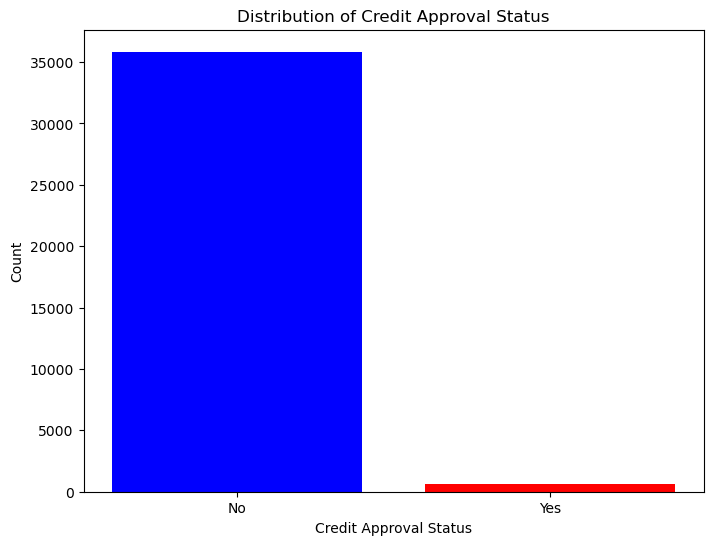

In [5]:
# Counts of each class in the target variable
merge_data = load_and_process_data()
class_counts = merge_data['dep_value'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values, color=['blue', 'red'])
plt.xlabel('Credit Approval Status')
plt.ylabel('Count')
plt.title('Distribution of Credit Approval Status')
plt.show()

In [16]:
merge_data = load_and_process_data()
data = merge_data.copy()

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 

In [44]:
data.describe()

UniqueID  NumberOfChildren   TotalIncome     AgeInDays  \
count  3.645700e+04      36457.000000  3.645700e+04  36457.000000   
mean   5.078227e+06          0.430315  1.866857e+05 -15975.173382   
std    4.187524e+04          0.742367  1.017892e+05   4200.549944   
min    5.008804e+06          0.000000  2.700000e+04 -25152.000000   
25%    5.042028e+06          0.000000  1.215000e+05 -19438.000000   
50%    5.074614e+06          0.000000  1.575000e+05 -15563.000000   
75%    5.115396e+06          1.000000  2.250000e+05 -12462.000000   
max    5.150487e+06         19.000000  1.575000e+06  -7489.000000   

       EmploymentDays  HasMobilePhone  HasWorkPhone      HasPhone  \
count    36457.000000         36457.0  36457.000000  36457.000000   
mean     59262.935568             1.0      0.225526      0.294813   
std     137651.334859             0.0      0.417934      0.455965   
min     -15713.000000             1.0      0.000000      0.000000   
25%      -3153.000000             1.0      0.000000      0.000000   
50%      -1552.000000             1.0      0.000000      0.000000   
75%       -408.000000             1.0      0.000000      1.000000   
max     365243.000000             1.0      1.000000      1.000000   

           HasEmail  FamilyMembersCount  MonthsSinceApplication  
count  36457.000000        36457.000000            36457.000000  
mean       0.089722            2.198453              -26.164193  
std        0.285787            0.911686               16.501854  
min        0.000000            1.000000              -60.000000  
25%        0.000000            2.000000              -39.000000  
50%        0.000000            2.000000              -24.000000  
75%        0.000000            3.000000              -12.000000  
max        1.000000           20.000000                0.000000

In [45]:
import pandas as pd

# Assuming you have your DataFrame named 'data'
data['EmploymentYears'] = data['EmploymentDays'] / 365
# Assuming you have your DataFrame named 'data'
data.drop('EmploymentDays', axis=1, inplace=True)

In [46]:
data.describe()

UniqueID  NumberOfChildren   TotalIncome     AgeInDays  \
count  3.645700e+04      36457.000000  3.645700e+04  36457.000000   
mean   5.078227e+06          0.430315  1.866857e+05 -15975.173382   
std    4.187524e+04          0.742367  1.017892e+05   4200.549944   
min    5.008804e+06          0.000000  2.700000e+04 -25152.000000   
25%    5.042028e+06          0.000000  1.215000e+05 -19438.000000   
50%    5.074614e+06          0.000000  1.575000e+05 -15563.000000   
75%    5.115396e+06          1.000000  2.250000e+05 -12462.000000   
max    5.150487e+06         19.000000  1.575000e+06  -7489.000000   

       HasMobilePhone  HasWorkPhone      HasPhone      HasEmail  \
count         36457.0  36457.000000  36457.000000  36457.000000   
mean              1.0      0.225526      0.294813      0.089722   
std               0.0      0.417934      0.455965      0.285787   
min               1.0      0.000000      0.000000      0.000000   
25%               1.0      0.000000      0.000000      0.000000   
50%               1.0      0.000000      0.000000      0.000000   
75%               1.0      0.000000      1.000000      0.000000   
max               1.0      1.000000      1.000000      1.000000   

       FamilyMembersCount  MonthsSinceApplication  EmploymentYears  
count        36457.000000            36457.000000     36457.000000  
mean             2.198453              -26.164193       162.364207  
std              0.911686               16.501854       377.126945  
min              1.000000              -60.000000       -43.049315  
25%              2.000000              -39.000000        -8.638356  
50%              2.000000              -24.000000        -4.252055  
75%              3.000000              -12.000000        -1.117808  
max             20.000000                0.000000      1000.665753

# Change columns name to easy to understand

In [24]:
# Assuming you have your DataFrame named 'df'
new_column_names = {
    'ID': 'UniqueID',
    'CODE_GENDER': 'Gender',
    'FLAG_OWN_CAR': 'OwnsCar',
    'FLAG_OWN_REALTY': 'OwnsProperty',
    'CNT_CHILDREN': 'NumberOfChildren',
    'AMT_INCOME_TOTAL': 'TotalIncome',
    'NAME_INCOME_TYPE': 'IncomeType',
    'NAME_EDUCATION_TYPE': 'EducationType',
    'NAME_FAMILY_STATUS': 'FamilyStatus',
    'NAME_HOUSING_TYPE': 'HousingType',
    'DAYS_BIRTH': 'AgeInDays',
    'DAYS_EMPLOYED': 'EmploymentDays',
    'FLAG_MOBIL': 'HasMobilePhone',
    'FLAG_WORK_PHONE': 'HasWorkPhone',
    'FLAG_PHONE': 'HasPhone',
    'FLAG_EMAIL': 'HasEmail',
    'OCCUPATION_TYPE': 'Occupation',
    'CNT_FAM_MEMBERS': 'FamilyMembersCount',
    'begin_month': 'MonthsSinceApplication',
    'dep_value': 'LoanApprovalStatus'
}

# Use the rename() method to change the column names
data.rename(columns=new_column_names, inplace=True)

In [25]:
profile = ProfileReport(data, title="Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [26]:
data.columns

Index(['UniqueID', 'Gender', 'OwnsCar', 'OwnsProperty', 'NumberOfChildren',
       'TotalIncome', 'IncomeType', 'EducationType', 'FamilyStatus',
       'HousingType', 'AgeInDays', 'EmploymentDays', 'HasMobilePhone',
       'HasWorkPhone', 'HasPhone', 'HasEmail', 'Occupation',
       'FamilyMembersCount', 'MonthsSinceApplication', 'LoanApprovalStatus'],
      dtype='object')

# Approval percentage per each type

In [37]:
import pandas as pd
import plotly.express as px

selected_columns = ['Gender', 'OwnsCar', 'OwnsProperty', 'NumberOfChildren',
       'TotalIncome', 'IncomeType', 'EducationType', 'FamilyStatus',
       'HousingType', 'AgeInDays', 'EmploymentDays', 'HasMobilePhone',
       'HasWorkPhone', 'HasPhone', 'HasEmail', 'Occupation',
       'FamilyMembersCount', 'MonthsSinceApplication']

for each_name in selected_columns:
    each_count = data.groupby([each_name, 'LoanApprovalStatus']).size().reset_index(name='Count')
    total_count = each_count.groupby(each_name)['Count'].transform('sum')
    each_count['Percentage'] = each_count['Count'] / total_count * 100

    fig = px.bar(each_count, x=f'{each_name}', y='Percentage', color='LoanApprovalStatus', barmode='group')

    fig.show()

# Distribution plot to check outlier 

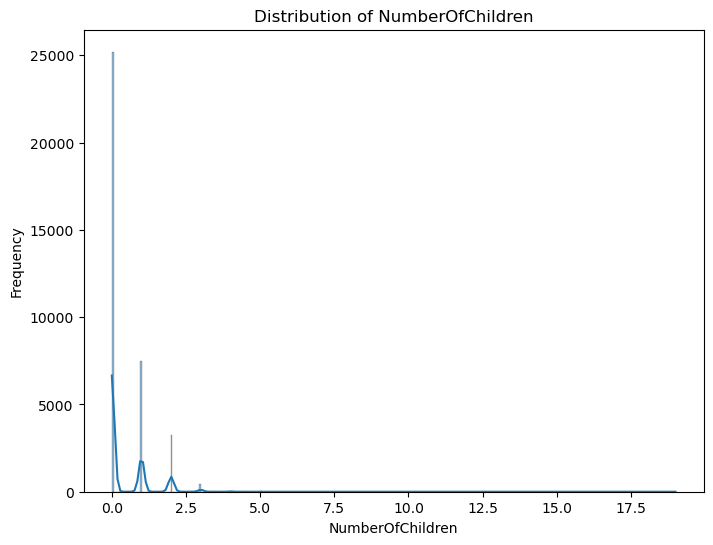

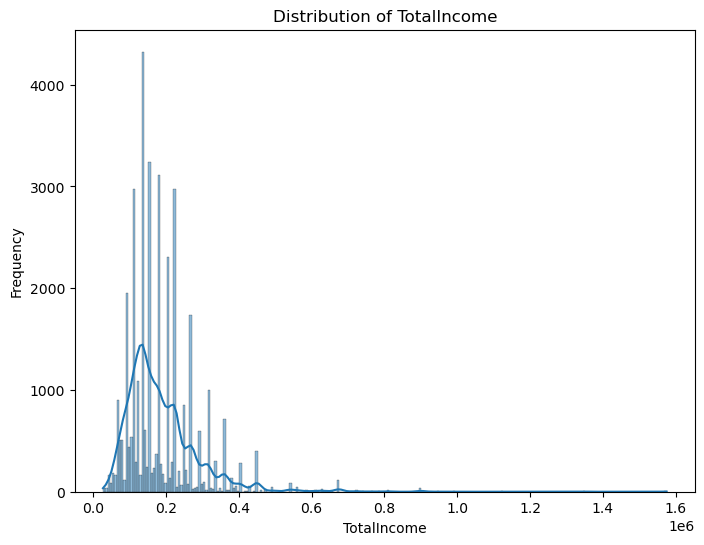

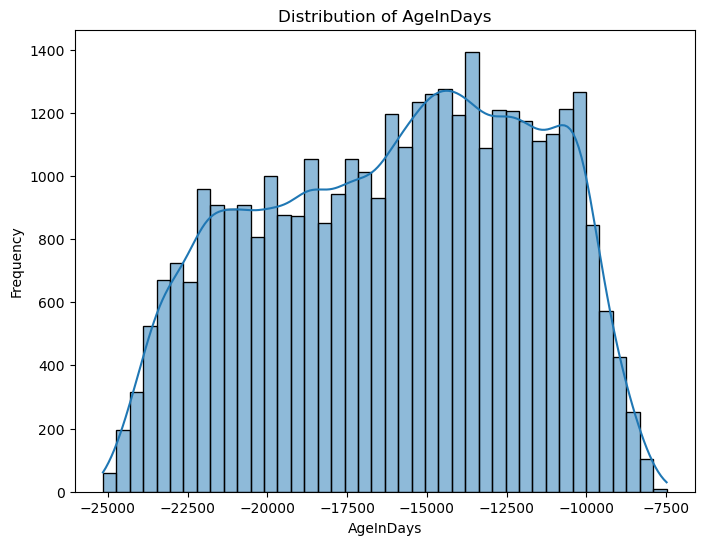

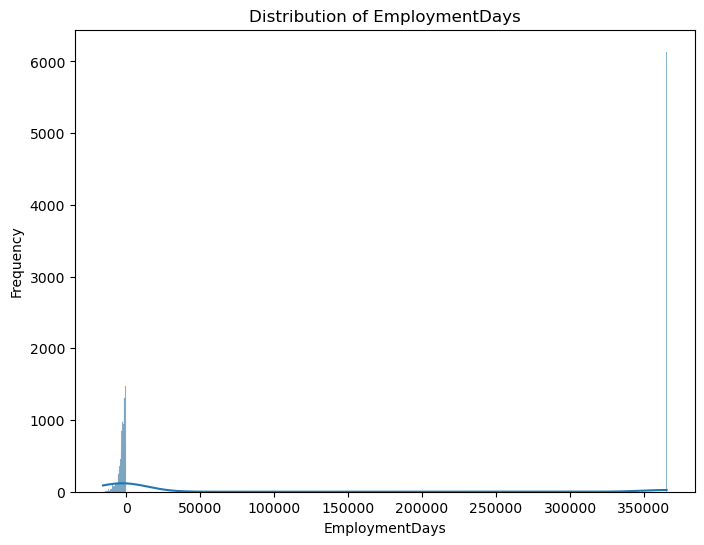

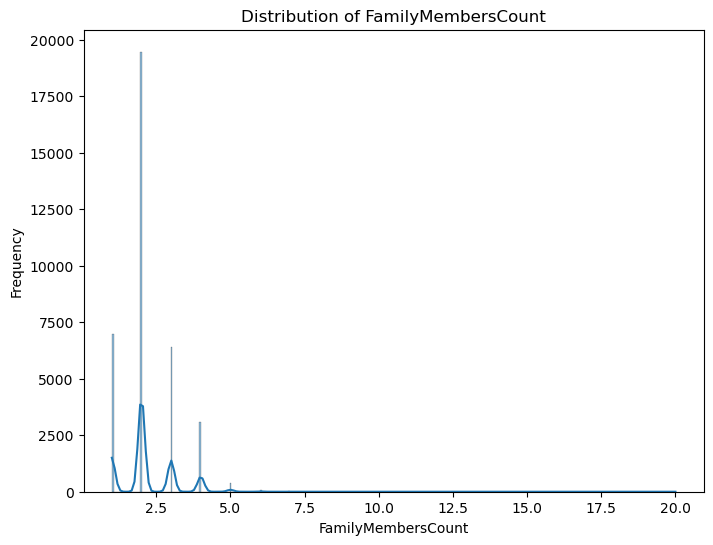

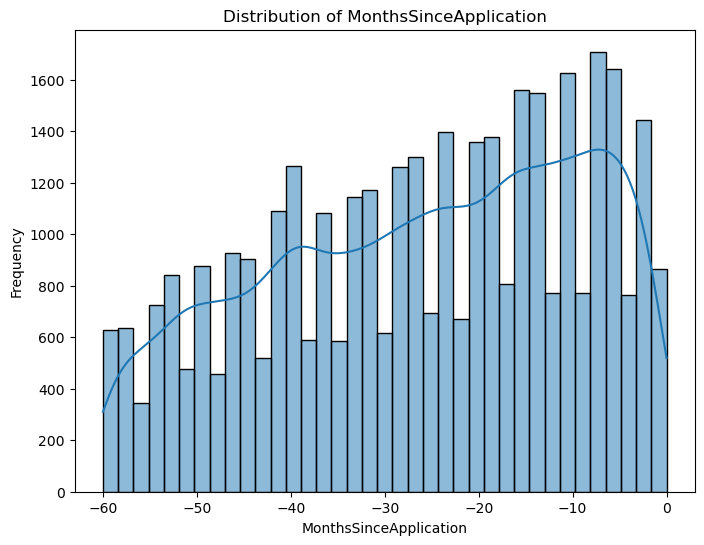

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Identify numerical columns
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns

# Plot distribution plots for numerical columns
for col in numerical_columns:
    if col not in ['UniqueID', 'HasWorkPhone', 'HasPhone', 'HasMobilePhone', 'HasEmail', 'LoanApprovalStatus']:
        plt.figure(figsize=(8, 6))
        sns.histplot(data[col], kde=True)
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {col}')
        plt.show()


# remove outlier 

In [51]:
# FOR CNT_CHILDREN COLUMN
q_hi = data['NumberOfChildren'].quantile(0.999)
q_low = data['NumberOfChildren'].quantile(0.001)
data = data[(data['NumberOfChildren']>q_low) & (data['NumberOfChildren']<q_hi)]

In [52]:
# FOR AMT_INCOME_TOTAL COLUMN
q_hi = data['TotalIncome'].quantile(0.999)
q_low = data['TotalIncome'].quantile(0.001)
data = data[(data['TotalIncome']>q_low) & (data['TotalIncome']<q_hi)]

In [54]:
#FOR CNT_FAM_MEMBERS COLUMN
q_hi = data['FamilyMembersCount'].quantile(0.999)
q_low = data['FamilyMembersCount'].quantile(0.001)
data= data[(data['FamilyMembersCount']>q_low) & (data['FamilyMembersCount']<q_hi)]

## plot agian to see results

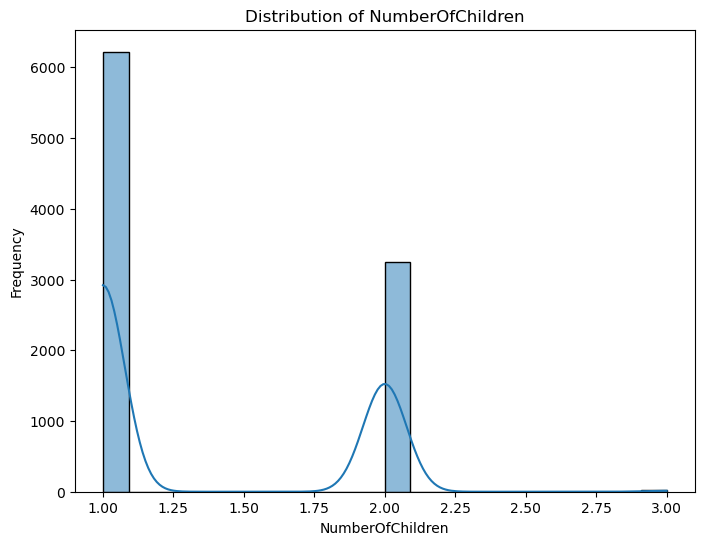

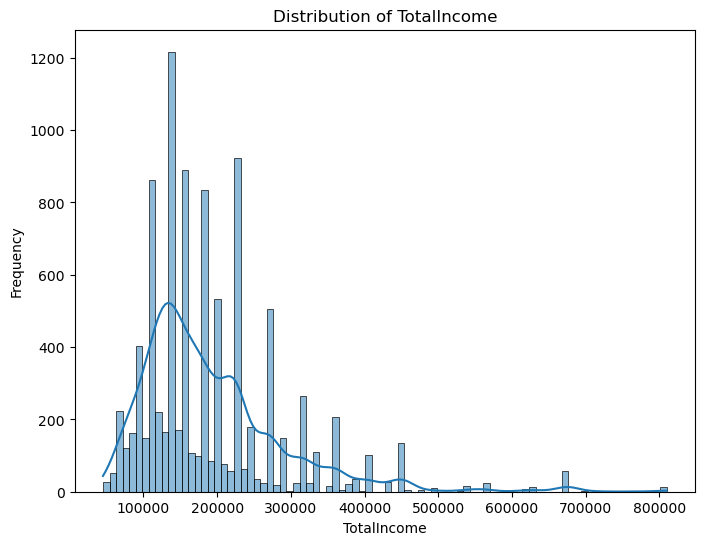

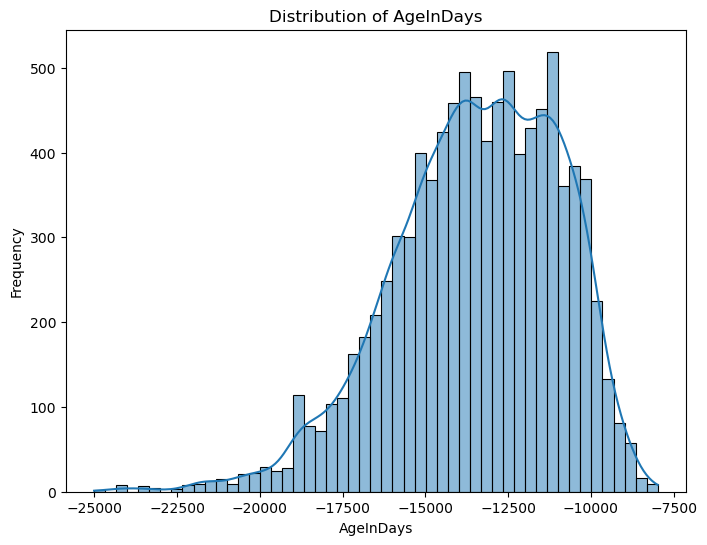

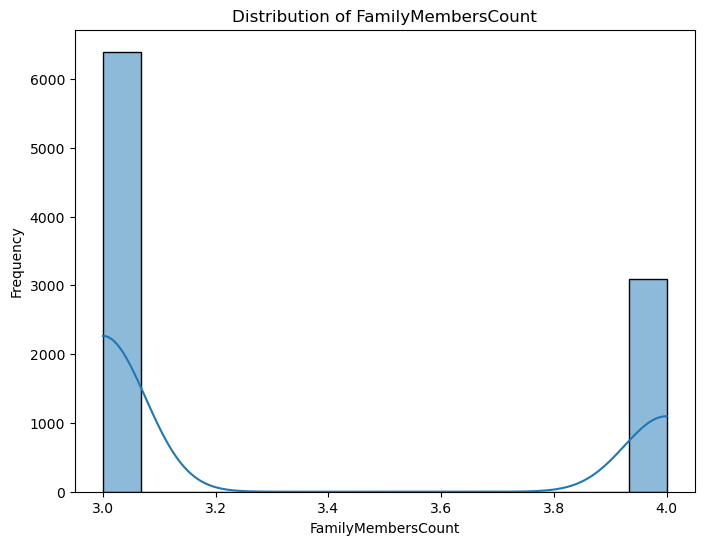

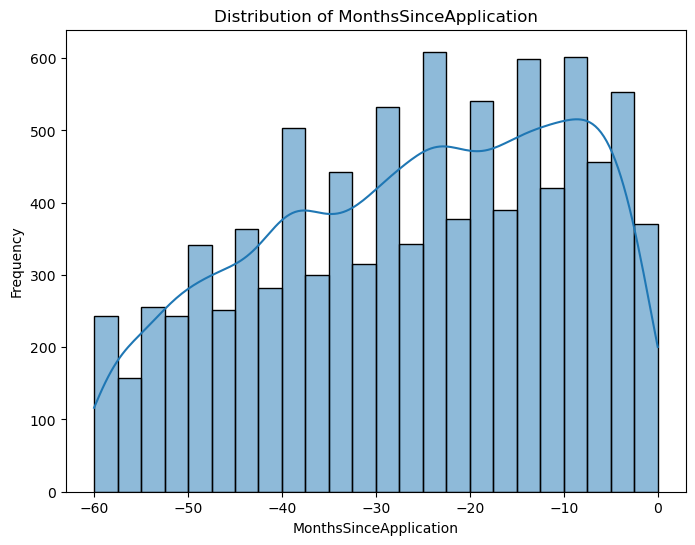

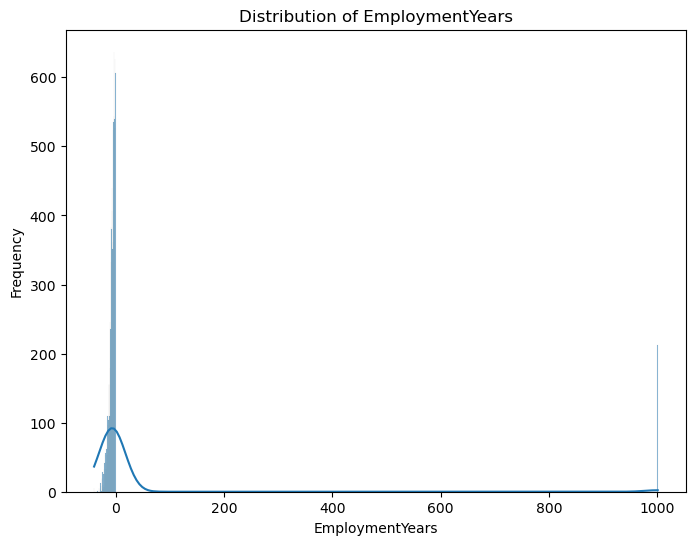

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Identify numerical columns
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns

# Plot distribution plots for numerical columns
for col in numerical_columns:
    if col not in ['UniqueID', 'HasWorkPhone', 'HasPhone', 'HasMobilePhone', 'HasEmail', 'LoanApprovalStatus']:
        plt.figure(figsize=(8, 6))
        sns.histplot(data[col], kde=True)
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {col}')
        plt.show()

In [62]:
data.columns

Index(['UniqueID', 'Gender', 'OwnsCar', 'OwnsProperty', 'NumberOfChildren',
       'TotalIncome', 'IncomeType', 'EducationType', 'FamilyStatus',
       'HousingType', 'AgeInDays', 'HasMobilePhone', 'HasWorkPhone',
       'HasPhone', 'HasEmail', 'Occupation', 'FamilyMembersCount',
       'MonthsSinceApplication', 'LoanApprovalStatus', 'EmploymentYears'],
      dtype='object')

# Scatter plot to understand relationships 

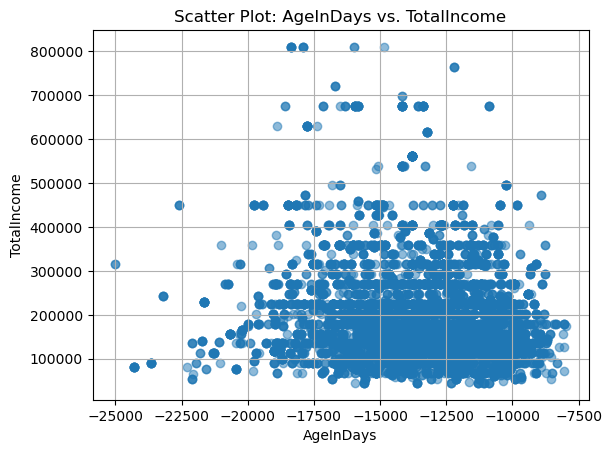

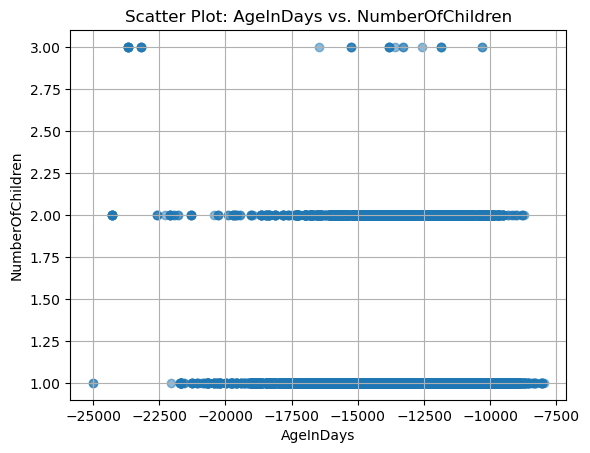

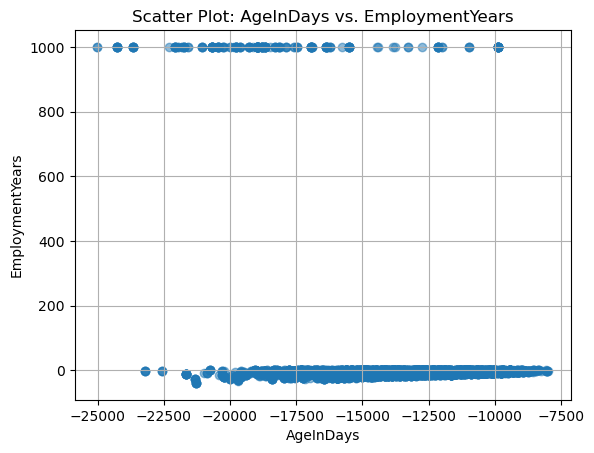

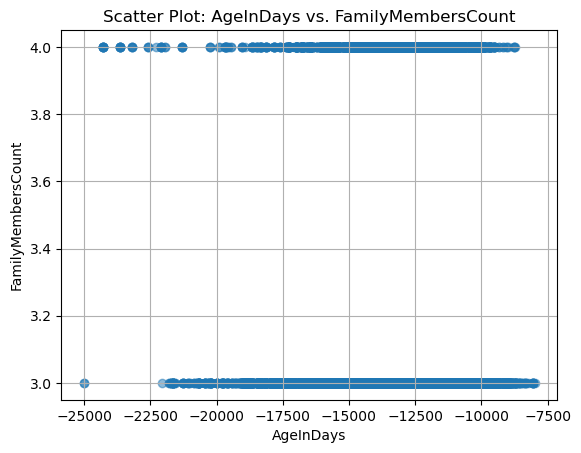

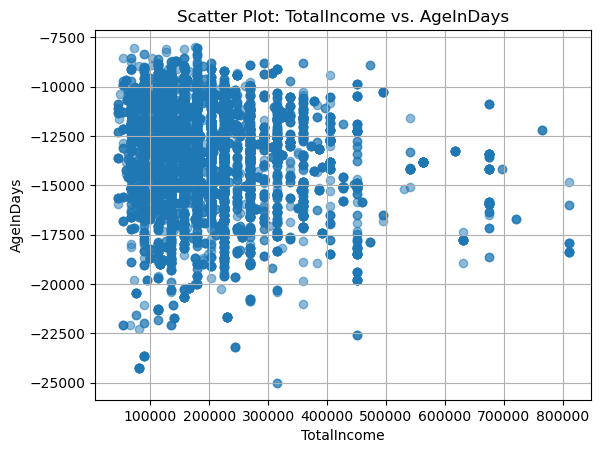

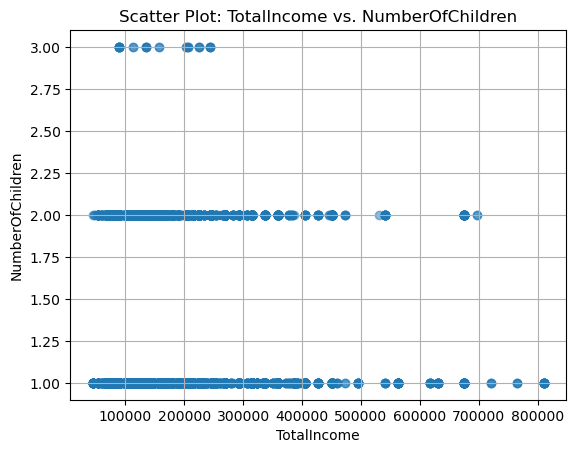

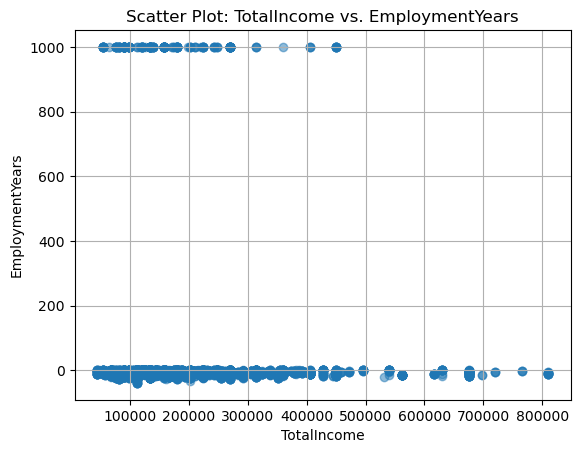

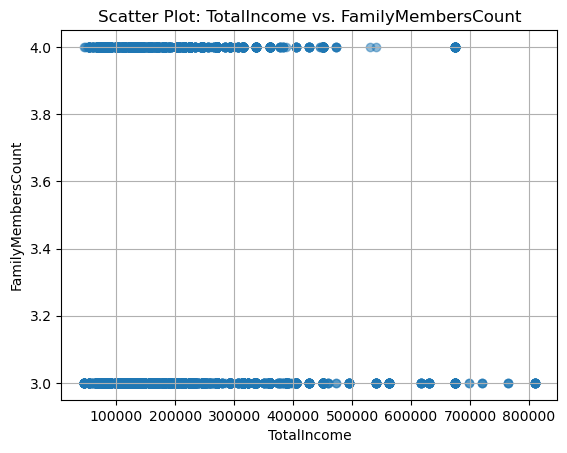

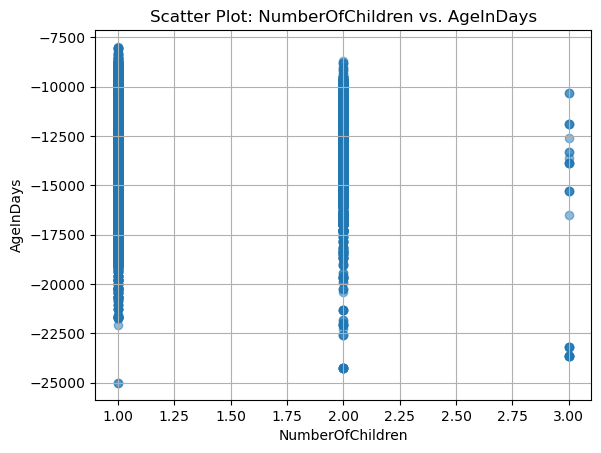

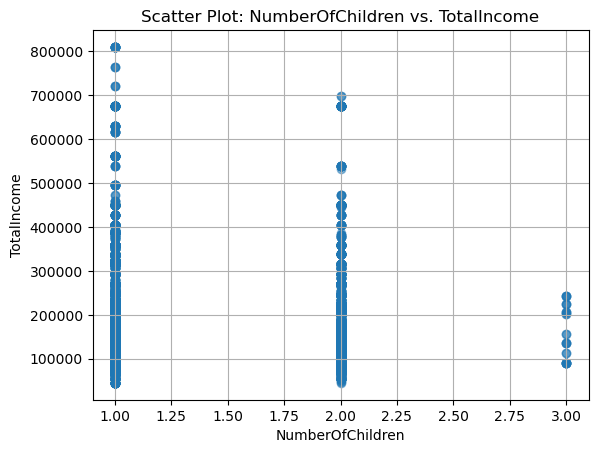

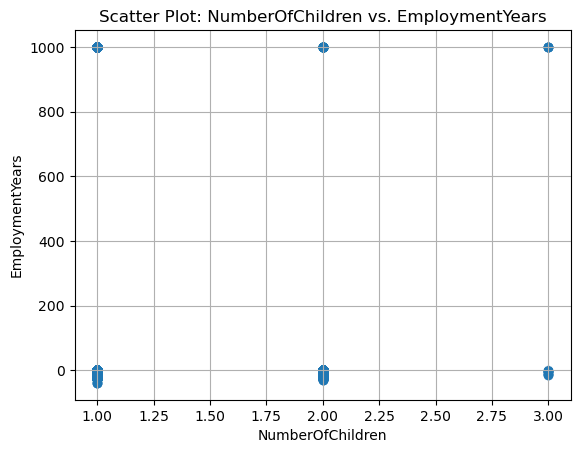

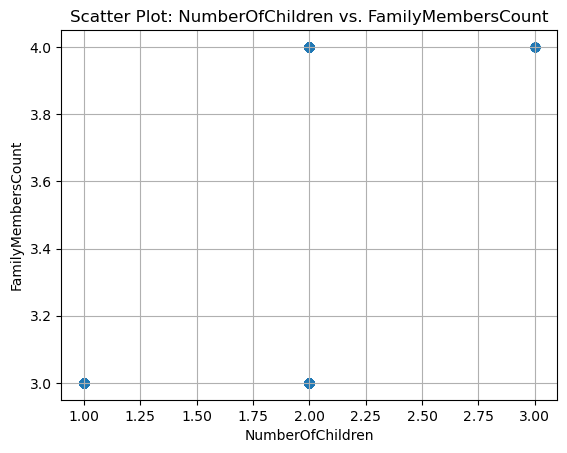

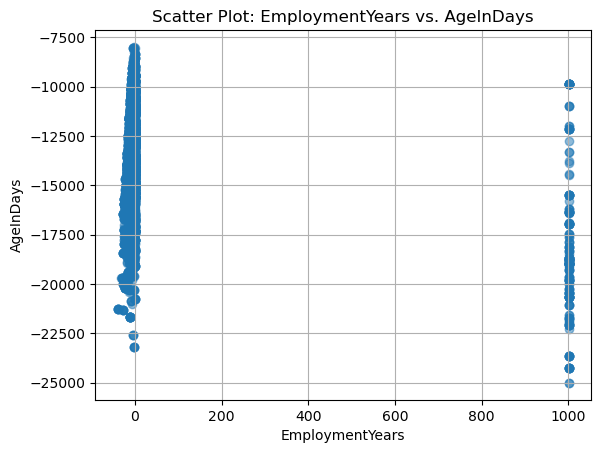

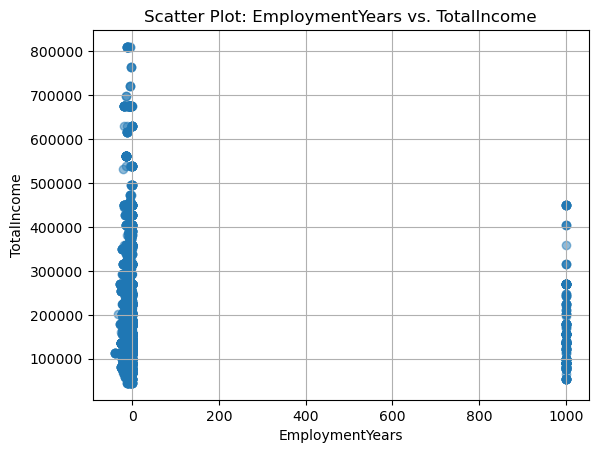

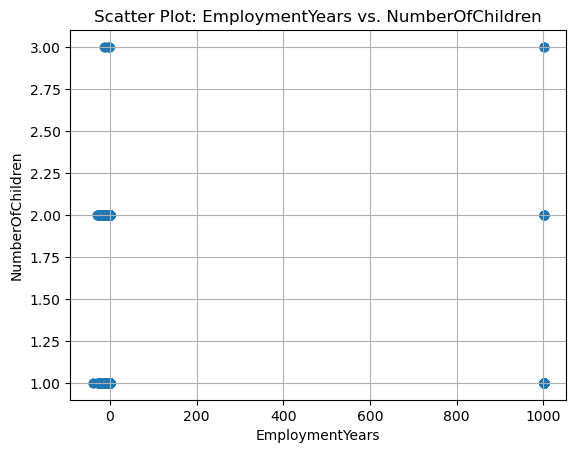

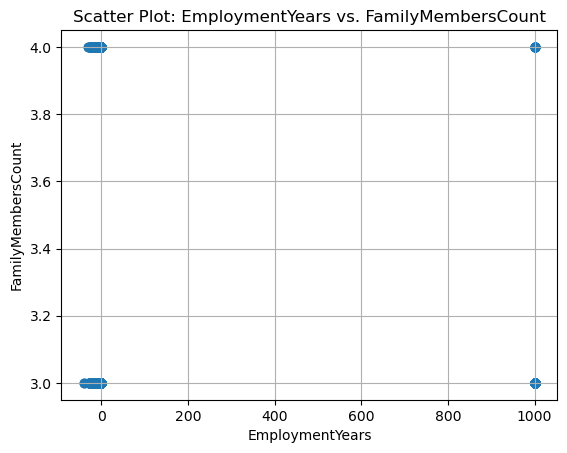

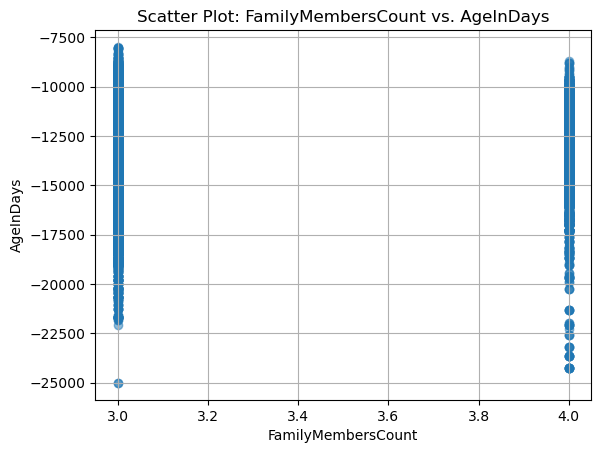

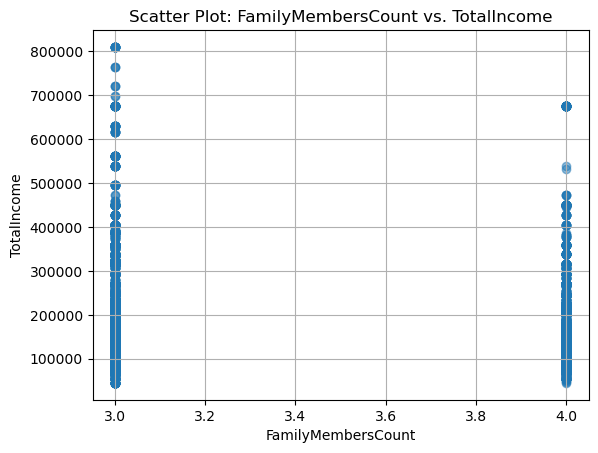

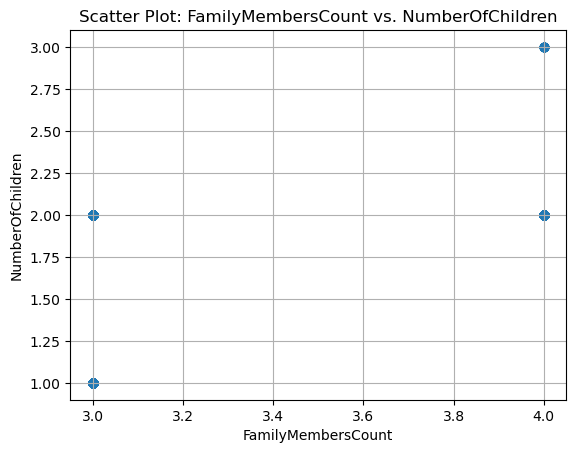

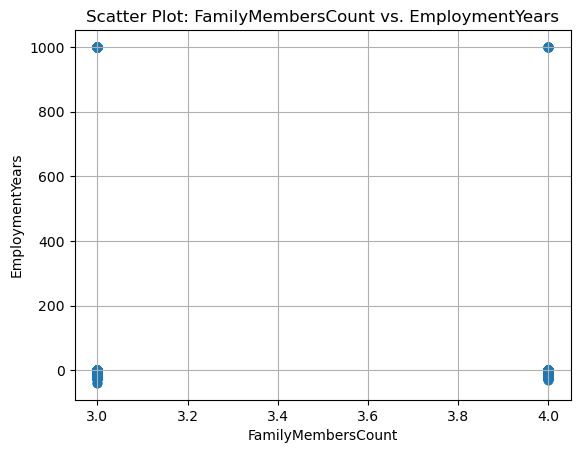

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is the DataFrame containing the data

# List of numerical columns for which we want to create scatter plots
numerical_columns = ['AgeInDays', 'TotalIncome', 'NumberOfChildren', 'EmploymentYears', 'FamilyMembersCount']

# Loop to create scatter plots for each combination
for x_column in numerical_columns:
    for y_column in numerical_columns:
        if x_column != y_column:
            plt.scatter(data[x_column], data[y_column], alpha=0.5)
            plt.xlabel(x_column)
            plt.ylabel(y_column)
            plt.title(f'Scatter Plot: {x_column} vs. {y_column}')
            plt.grid(True)
            plt.show()